# Capstone Project - Predictive Analysis of Singapore's Housing Price (week 1 & 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Predictive Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

Singapore is one of the largest metropolises in the world where over 5 million people live and 2nd densed country in the world with 7,804 persons per square kilometer. Singapore are subdivided into 28 districts in total. As a potential property investor in Singapore, identifying underpriced and overpirced properties is crucial. The property prices are well-known to correlate with three major factors: 1) type property tenure, 2) distance from city central area, and 3) proximity with major shopping/restaurant areas.

In this project, I will first gather these three factors and current housing prices. Then, I will derive housing prices formula based on these three factors. Based on the equation, I will shortlist top twenties undervalued locations (outliers) for further investigation and top twenties overvalued ones for avoiding.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* recent property price in various neighbors using **webscraping from websites**
* estates' locations and driving distances from city central area using **GoogleMap API**
* proximity with major shopping areas using **FourSquare API**

#### Web scraping latest transactions
**Resulted Data: Recent Price Table**
* The recent one-month transactions will be web-scraped and create table

In [2]:
# Import libraries
from bs4 import BeautifulSoup
import requests
import pandas as pd

# get xml
source = requests.get('https://www.squarefoot.com.sg/latest-transactions/sale/residential/condominium').text
soup = BeautifulSoup(source,'lxml')
tbodys = soup.find_all('tbody')

# get column names
column_name = []
for th in soup.find('thead').find_all('th'):
    column_name.append(th.text.strip())

# get table
table = []
for tr in tbodys[1].find_all('tr'):
    row = []
    for td in tr.find_all('td'):
        row.append(td.text.strip())
    table.append(row)

# create table
df = pd.DataFrame(table)

# add column name
df.columns = column_name
df.head(10)

,Date,District,Project Name,Address,PropertyType,Tenure,Area(sq ft),Typeof Area,Price($psf),Price($)
0,9 Apr 2019,20,SKY HABITAT,,Condominium,99 Yrs FROM 2011,710,Strata,"1,633","1,160,000"
1,9 Apr 2019,27,THE ESTUARY,,Condominium,99 Yrs FROM 2008,926,Strata,929,"860,000"
2,9 Apr 2019,15,THE WATERSIDE,,Condominium,Freehold,"2,142",Strata,"1,634","3,500,000"
3,8 Apr 2019,16,AQUARIUS BY THE PARK,,Condominium,99 Yrs FROM 1996,"1,206",Strata,970,"1,170,000"
4,8 Apr 2019,27,THE ESTUARY,,Condominium,99 Yrs FROM 2008,"1,119",Strata,945,"1,058,000"
5,8 Apr 2019,23,REGENT HEIGHTS,,Condominium,99 Yrs FROM 1995,"1,023",Strata,836,"855,000"
6,8 Apr 2019,15,ELLIOT AT THE EAST COAST,,Condominium,Freehold,"1,313",Strata,"1,432","1,880,000"
7,8 Apr 2019,10,WATERFALL GARDENS,,Condominium,Freehold,"1,830",Strata,"1,667","3,050,000"
8,8 Apr 2019,16,THE BAYSHORE,,Condominium,99 Yrs FROM 1993,958,Strata,939,"900,000"
9,8 Apr 2019,5,THE TRILINQ,,Condominium,99 Yrs FROM 2012,936,Strata,"1,623","1,520,148"


* Clean Data

In [10]:
df_process = df.copy()
# drop unnecessary columns
df_process.drop(['Address','Typeof Area', 'Area(sq ft)', 'Price($)','PropertyType'], axis=1)

# formating
df_process["Price($psf)"] = df_process["Price($psf)"].str.replace(",","").astype(float)
df_process = df_process.groupby(['Project Name','Tenure'])['Price($psf)'].mean().reset_index()
df_process = df_process.sort_values(by='Project Name', ascending=False)
# df_process.set_index('Project Name', inplace=True)
df_process = df_process.iloc[2:]
df_process.head(10)

,Project Name,Tenure,Price($psf)
309,YISHUN EMERALD,99 Yrs FROM 1998,675.000000
308,WOODHAVEN,99 Yrs FROM 2011,1025.500000
307,WOODGROVE CONDOMINIUM,99 Yrs FROM 1997,685.500000
306,WINDY HEIGHTS,Freehold,911.000000
305,WEST BAY CONDOMINIUM,99 Yrs FROM 1991,842.000000
304,WATERVIEW,99 Yrs FROM 2010,1092.500000
303,WATERFRONT WAVES,99 Yrs FROM 2007,1068.000000
302,WATERFRONT KEY,99 Yrs FROM 2007,1211.666667
301,WATERFRONT ISLE,99 Yrs FROM 2009,1179.600000
300,WATERFRONT GOLD,99 Yrs FROM 2009,1264.000000


#### Distance from Central point
* From the transaction dataframe, each transaction location will be collected from google API and integrated into the transaction dataframe.
* From the location information, the central point of each district will be computed.

In [6]:
ProjectNames = df_process.index.values

In [8]:
#!pip install googlemaps
# import libraries
import googlemaps
from pandas.io.json import json_normalize

# initilize googlemaps api
gmaps = googlemaps.Client(key='YOUR API KEY')
geocodes = []

# get geo locations for all locations
for ProjectName in ProjectNames:
    address = ProjectName + 'Condo Singapore'
    geocode_result = gmaps.geocode(address)    
    json_normalize_value = json_normalize(geocode_result[0])
    lng = json_normalize_value['geometry.viewport.northeast.lng'].values[0]
    lat = json_normalize_value['geometry.viewport.northeast.lat'].values[0]
    geocodes.append([ProjectName,lng,lat])

# create geo_dataframe
df_geocodes = pd.DataFrame(geocodes)
df_geocodes.columns = ['Project Name','Longitude','Latitude']
df_geocodes.head(10)

Requirement not upgraded as not directly required: requests<3.0,>=2.11.1 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from googlemaps)
Requirement not upgraded as not directly required: chardet<3.1.0,>=3.0.2 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from requests<3.0,>=2.11.1->googlemaps)
Requirement not upgraded as not directly required: idna<2.7,>=2.5 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from requests<3.0,>=2.11.1->googlemaps)
Requirement not upgraded as not directly required: urllib3<1.23,>=1.21.1 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from requests<3.0,>=2.11.1->googlemaps)
Requirement not upgraded as not directly required: certifi>=2017.4.17 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from requests<3.0,>=2.11.1->googlemaps)
  Running setup.py bdist_wheel for googlemaps ... done
  Stored in directory: /home/dsxuser/.cache/pip/wheels/3c/3f/25/ce6d7722dba07e5d4a12d27ab38f3d7add65ef43171b

,Project Name,Longitude,Latitude
0,YISHUN EMERALD,103.831704,1.440107
1,WOODHAVEN,103.785410,1.431580
2,WOODGROVE CONDOMINIUM,103.783327,1.430415
3,WINDY HEIGHTS,103.911559,1.328202
4,WEST BAY CONDOMINIUM,103.766799,1.300242
5,WATERVIEW,103.927682,1.350193
6,WATERFRONT WAVES,103.930964,1.338887
7,WATERFRONT KEY,103.932551,1.338767
8,WATERFRONT ISLE,103.929216,1.340098
9,WATERFRONT GOLD,103.930007,1.339721


In [11]:
df_combined = pd.merge(df_process, df_geocodes, on='Project Name', how='inner')
df_combined.head(10)

,Project Name,Tenure,Price($psf),Longitude,Latitude
0,YISHUN EMERALD,99 Yrs FROM 1998,675.000000,103.831704,1.440107
1,WOODHAVEN,99 Yrs FROM 2011,1025.500000,103.785410,1.431580
2,WOODGROVE CONDOMINIUM,99 Yrs FROM 1997,685.500000,103.783327,1.430415
3,WINDY HEIGHTS,Freehold,911.000000,103.911559,1.328202
4,WEST BAY CONDOMINIUM,99 Yrs FROM 1991,842.000000,103.766799,1.300242
5,WATERVIEW,99 Yrs FROM 2010,1092.500000,103.927682,1.350193
6,WATERFRONT WAVES,99 Yrs FROM 2007,1068.000000,103.930964,1.338887
7,WATERFRONT KEY,99 Yrs FROM 2007,1211.666667,103.932551,1.338767
8,WATERFRONT ISLE,99 Yrs FROM 2009,1179.600000,103.929216,1.340098
9,WATERFRONT GOLD,99 Yrs FROM 2009,1264.000000,103.930007,1.339721


* Plot the location on the map

In [13]:
Map_center = [(df_combined.Latitude.max()+df_combined.Latitude.min())/2,(df_combined.Longitude.max()+df_combined.Longitude.min())/2]
!pip install folium
import folium
m = folium.Map(
    location=Map_center,
    zoom_start=12
)

for index, row in df_combined.iterrows():   
    Latitude = row['Latitude']
    Longitude = row['Longitude']
    ProjectName = row['Project Name'].replace('\'',' ')
    folium.Marker([Latitude, Longitude], popup= ProjectName).add_to(m)
    
m

    100% |████████████████████████████████| 92kB 6.9MB/s eta 0:00:01
Requirement not upgraded as not directly required: requests in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from folium)
Requirement not upgraded as not directly required: six in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from folium)
Requirement not upgraded as not directly required: numpy in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from folium)
Requirement not upgraded as not directly required: jinja2 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from folium)
Requirement not upgraded as not directly required: chardet<3.1.0,>=3.0.2 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from requests->folium)
Requirement not upgraded as not directly required: idna<2.7,>=2.5 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from requests->folium)
Requirement not upgraded as not directly required: urllib3<1.23,>=1.21.1 in /opt/conda/envs/DSX-Py

#### Distance from city central area and map display (GOOGLE API)
**Resulted Data: Distance from City Central**
* District names will be webscraped and a new dataframe (district's name, location, average price, and distance from city central) will be created.
* District labels will be display on the Singapore Map.

In [14]:
import geopy.distance
geo_dist = []
for index, row in df_combined.iterrows():   
    Latitude = row['Latitude']
    Longitude = row['Longitude']
    coords_place = (Latitude, Longitude)
    coords_city_central = (1.2830, 103.8513)             # City Central location   
    geo_dist.append(geopy.distance.vincenty(coords_place, coords_city_central).km)
df_combined['DistanceWithCentral(km)'] = geo_dist
df_combined.head(10)    

,Project Name,Tenure,Price($psf),Longitude,Latitude,DistanceWithCentral(km)
0,YISHUN EMERALD,99 Yrs FROM 1998,675.000000,103.831704,1.440107,17.508434
1,WOODHAVEN,99 Yrs FROM 2011,1025.500000,103.785410,1.431580,17.991419
2,WOODGROVE CONDOMINIUM,99 Yrs FROM 1997,685.500000,103.783327,1.430415,17.970155
3,WINDY HEIGHTS,Freehold,911.000000,103.911559,1.328202,8.364010
4,WEST BAY CONDOMINIUM,99 Yrs FROM 1991,842.000000,103.766799,1.300242,9.595547
5,WATERVIEW,99 Yrs FROM 2010,1092.500000,103.927682,1.350193,11.289942
6,WATERFRONT WAVES,99 Yrs FROM 2007,1068.000000,103.930964,1.338887,10.807098
7,WATERFRONT KEY,99 Yrs FROM 2007,1211.666667,103.932551,1.338767,10.944877
8,WATERFRONT ISLE,99 Yrs FROM 2009,1179.600000,103.929216,1.340098,10.726281
9,WATERFRONT GOLD,99 Yrs FROM 2009,1264.000000,103.930007,1.339721,10.773228


In [15]:
low_lease_year = df_combined['Tenure'].str.contains('99 Yrs|100 Yrs|103 Yrs')
freehold = (df_combined['Tenure']=='Freehold')*1
Yr_From = df_combined[low_lease_year]['Tenure'].str[-4:]
low_lease_year = low_lease_year * 1
df_combined['low_lease_year'] = low_lease_year
df_combined['freehold'] = freehold
df_combined['Yr_From'] = Yr_From
df_combined['Yr_From'].fillna(2019, inplace=True)
df_combined.head(10)

,Project Name,Tenure,Price($psf),Longitude,Latitude,DistanceWithCentral(km),low_lease_year,freehold,Yr_From
0,YISHUN EMERALD,99 Yrs FROM 1998,675.000000,103.831704,1.440107,17.508434,1,0,1998
1,WOODHAVEN,99 Yrs FROM 2011,1025.500000,103.785410,1.431580,17.991419,1,0,2011
2,WOODGROVE CONDOMINIUM,99 Yrs FROM 1997,685.500000,103.783327,1.430415,17.970155,1,0,1997
3,WINDY HEIGHTS,Freehold,911.000000,103.911559,1.328202,8.364010,0,1,2019
4,WEST BAY CONDOMINIUM,99 Yrs FROM 1991,842.000000,103.766799,1.300242,9.595547,1,0,1991
5,WATERVIEW,99 Yrs FROM 2010,1092.500000,103.927682,1.350193,11.289942,1,0,2010
6,WATERFRONT WAVES,99 Yrs FROM 2007,1068.000000,103.930964,1.338887,10.807098,1,0,2007
7,WATERFRONT KEY,99 Yrs FROM 2007,1211.666667,103.932551,1.338767,10.944877,1,0,2007
8,WATERFRONT ISLE,99 Yrs FROM 2009,1179.600000,103.929216,1.340098,10.726281,1,0,2009
9,WATERFRONT GOLD,99 Yrs FROM 2009,1264.000000,103.930007,1.339721,10.773228,1,0,2009


#### Get numbers of venue in each property location (FOURSQUARE)
**Resulted Data: Nearby venues in the district**
* Four square data will be used to find numbers of venues in each district area. 
* The data will be integarated into the district dataframe.

Now we have the district dataframe consisting of districts' name, location, distance from city central, nearby primary school ranking, nearby secondary school ranking, and the average price (psf)

In [18]:
# generate api url
def get_4sq_api_url(latitude,longitude):
    VERSION = '20180604'
    radius=1000
    LIMIT=300
    CLIENT_ID='YOUR ID' 
    CLIENT_SECRET='YOUR SECRET' 
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
    return url

In [19]:
import requests
number_of_nearby_restaurant = []
for index, row in df_combined.iterrows():   
    Latitude = row['Latitude']
    Longitude = row['Longitude']
    url = get_4sq_api_url(Latitude,Longitude)    
    results = requests.get(url).json()
    number_of_nearby_restaurant.append(len(results['response']['groups'][0]['items']))
df_combined['number_of_nearby_restaurant'] = number_of_nearby_restaurant
df_combined.head(10)

,Project Name,Tenure,Price($psf),Longitude,Latitude,DistanceWithCentral(km),low_lease_year,freehold,Yr_From,number_of_nearby_restaurant
0,YISHUN EMERALD,99 Yrs FROM 1998,675.000000,103.831704,1.440107,17.508434,1,0,1998,53
1,WOODHAVEN,99 Yrs FROM 2011,1025.500000,103.785410,1.431580,17.991419,1,0,2011,56
2,WOODGROVE CONDOMINIUM,99 Yrs FROM 1997,685.500000,103.783327,1.430415,17.970155,1,0,1997,62
3,WINDY HEIGHTS,Freehold,911.000000,103.911559,1.328202,8.364010,0,1,2019,38
4,WEST BAY CONDOMINIUM,99 Yrs FROM 1991,842.000000,103.766799,1.300242,9.595547,1,0,1991,64
5,WATERVIEW,99 Yrs FROM 2010,1092.500000,103.927682,1.350193,11.289942,1,0,2010,33
6,WATERFRONT WAVES,99 Yrs FROM 2007,1068.000000,103.930964,1.338887,10.807098,1,0,2007,31
7,WATERFRONT KEY,99 Yrs FROM 2007,1211.666667,103.932551,1.338767,10.944877,1,0,2007,35
8,WATERFRONT ISLE,99 Yrs FROM 2009,1179.600000,103.929216,1.340098,10.726281,1,0,2009,41
9,WATERFRONT GOLD,99 Yrs FROM 2009,1264.000000,103.930007,1.339721,10.773228,1,0,2009,39


Looking good. We have a data frame consisting of all the required information

## Methodology <a name="methodology"></a>

In this project we will first plot price against *Distance from Central*, *Having Low Lease Year*, *Being Freehold Property*, *Lease Year From*, and *Number of nearby restaurant within 1km* and analyse the parameter relationships. After that, multivariable linear regression will be used to build properties price model. Based on the model, top twenties undervalued and overvalued properties will be shortlisted for further study.

## Predictive Analysis <a name="analysis"></a>

**Let first plot price histogram**

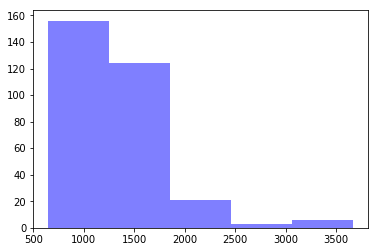

In [21]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
y = df_combined['Price($psf)']
num_bins = 5
n, bins, patches = plt.hist(y, num_bins, facecolor='blue', alpha=0.5)
plt.show()

**Display Price Map (High to Low)**
* Darkred,
* Red,
* Orange,
* Blue,
* Green, and
* Gray

In [23]:
# plot them on the map

Map_center = [(df_combined.Latitude.max()+df_combined.Latitude.min())/2,(df_combined.Longitude.max()+df_combined.Longitude.min())/2]

import folium
m = folium.Map(
    location=Map_center,
    zoom_start=12
)

color_list=['gray','green','blue','orange','red','darkred']

for index, row in df_combined.iterrows():   
    Latitude = row['Latitude']
    Longitude = row['Longitude']
    ProjectName = row['Project Name'].replace('\'',' ')    
    color = color_list[(sum((bins < row['Price($psf)'])*1))]
    folium.Marker([Latitude, Longitude], popup= ProjectName, icon=folium.Icon(color=color)).add_to(m)
m

**Seperate X and Y from the DataFrame**

In [26]:
df_x = df_combined[['DistanceWithCentral(km)','low_lease_year','Yr_From','freehold','number_of_nearby_restaurant']]
df_x.Yr_From = pd.to_numeric(df_x.Yr_From, errors='coerce')
df_x.head(10)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,DistanceWithCentral(km),low_lease_year,Yr_From,freehold,number_of_nearby_restaurant
0,17.508434,1,1998,0,53
1,17.991419,1,2011,0,56
2,17.970155,1,1997,0,62
3,8.364010,0,2019,1,38
4,9.595547,1,1991,0,64
5,11.289942,1,2010,0,33
6,10.807098,1,2007,0,31
7,10.944877,1,2007,0,35
8,10.726281,1,2009,0,41
9,10.773228,1,2009,0,39


In [27]:
df_y = df_combined[['Price($psf)']]
df_y.head(10)

,Price($psf)
0,675.000000
1,1025.500000
2,685.500000
3,911.000000
4,842.000000
5,1092.500000
6,1068.000000
7,1211.666667
8,1179.600000
9,1264.000000


**Analyse individual relationship between parameters**
* Distance from Central

correlation : -0.658783 and p_value : 5.902929E-40


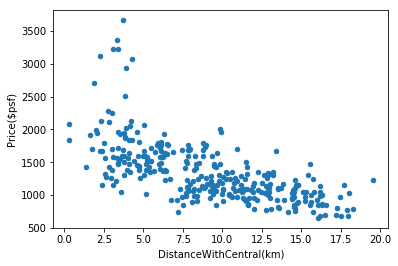

In [28]:
corr, p_value = pearsonr(df_x['DistanceWithCentral(km)'].values, df_y.values.flatten())
print("correlation : {:f} and p_value : {:E}".format(corr, p_value))
df_combined.plot.scatter(x='DistanceWithCentral(km)',y='Price($psf)')
plt.figure()

* Low Lease Year

correlation : -0.404099 and p_value : 1.318236E-13


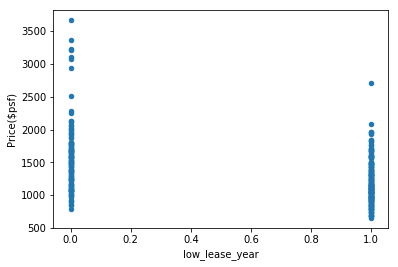

In [29]:
import matplotlib.pyplot as plt
corr, p_value = pearsonr(df_x['low_lease_year'].values, df_y.values.flatten())
print("correlation : {:f} and p_value : {:E}".format(corr, p_value))
df_combined.plot.scatter(x='low_lease_year',y='Price($psf)')
plt.figure()

* Lease Year From

correlation : 0.170763 and p_value : 2.555905E-03


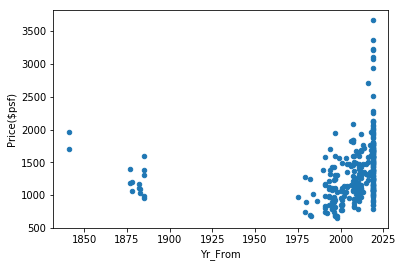

In [36]:
df_combined['Yr_From'] = pd.to_numeric(df_combined['Yr_From'], errors='coerce')
corr, p_value = pearsonr(df_x['Yr_From'].values, df_y.values.flatten())

print("correlation : {:f} and p_value : {:E}".format(corr, p_value))
df_combined.plot.scatter(x='Yr_From',y='Price($psf)')
plt.figure()

* FreeHold Property

correlation : 0.398086 and p_value : 3.241185E-13


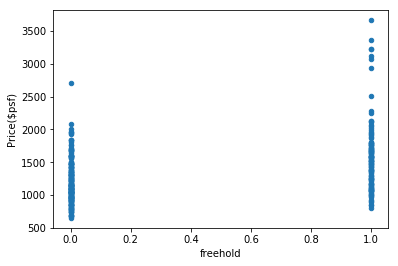

In [37]:
corr, p_value = pearsonr(df_x['freehold'].values, df_y.values.flatten())
print("correlation : {:f} and p_value : {:E}".format(corr, p_value))
df_combined.plot.scatter(x='freehold',y='Price($psf)')
plt.figure()

* Number of Restaurants within 1 Km

correlation : 0.483577 and p_value : 1.422353E-19


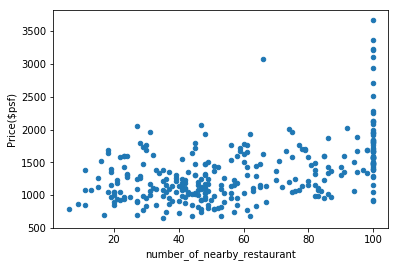

In [38]:
corr, p_value = pearsonr(df_x['number_of_nearby_restaurant'].values, df_y.values.flatten())
print("correlation : {:f} and p_value : {:E}".format(corr, p_value))
df_combined.plot.scatter(x='number_of_nearby_restaurant',y='Price($psf)')
plt.figure()

**Preprocessing**

In [39]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler.fit(df_x)
X = scaler.transform(df_x)
X[0:10]

array([[ 1.91905315,  0.78395366, -0.17247636, -0.76794765, -0.21657185],
       [ 2.02898886,  0.78395366,  0.25395293, -0.76794765, -0.10840223],
       [ 2.02414882,  0.78395366, -0.20527862, -0.76794765,  0.10793699],
       [-0.16237271, -1.27558561,  0.51637095,  1.3021721 , -0.75741991],
       [ 0.11794593,  0.78395366, -0.40209213, -0.76794765,  0.18005006],
       [ 0.50361894,  0.78395366,  0.22115067, -0.76794765, -0.93770259],
       [ 0.39371544,  0.78395366,  0.12274391, -0.76794765, -1.00981567],
       [ 0.42507637,  0.78395366,  0.12274391, -0.76794765, -0.86558952],
       [ 0.37532016,  0.78395366,  0.18834842, -0.76794765, -0.64925029],
       [ 0.38600614,  0.78395366,  0.18834842, -0.76794765, -0.72136337]])

In [40]:
y = df_y.values
y[0:10]

array([[  675.        ],
       [ 1025.5       ],
       [  685.5       ],
       [  911.        ],
       [  842.        ],
       [ 1092.5       ],
       [ 1068.        ],
       [ 1211.66666667],
       [ 1179.6       ],
       [ 1264.        ]])

**Build Price Model**

In [41]:
import numpy as np
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit (X, y)
# The coefficients
print ('Coefficients: ', regr.coef_)

y_hat= regr.predict(X)
print("Absolute Mean Error is " + "{:.2%}".format(np.mean(abs((y_hat - y)/y))))

Coefficients:  [[-238.43739133 -177.16215097   19.45595178  -87.68329135   61.57526926]]
Absolute Mean Error is 17.11%


**Shortlist Top 20 Undervalued Property Locations**

In [44]:
df_conclude = df_combined.copy()
df_conclude['PriceDifferentPercent'] = (y_hat - y)/y
df_conclude.index = df_conclude['Project Name']
# df_conclude = df_conclude.drop('Project Name',axis =1)
df_conclude = df_conclude.sort_values('PriceDifferentPercent', axis = 0, ascending = True)
df_conclude.head(20)

,Project Name,Tenure,Price($psf),Longitude,Latitude,DistanceWithCentral(km),low_lease_year,freehold,Yr_From,number_of_nearby_restaurant,PriceDifferentPercent
Project Name,,,,,,,,,,,
3 ORCHARD BY-THE-PARK,3 ORCHARD BY-THE-PARK,Freehold,3666.000000,103.826118,1.304599,3.682151,0,1,2019,100,-0.494647
KANDIS RESIDENCE,KANDIS RESIDENCE,99 Yrs FROM 2016,1235.000000,103.838741,1.459187,19.531974,1,0,2016,21,-0.488461
TWENTYONE ANGULLIA PARK,TWENTYONE ANGULLIA PARK,Freehold,3361.500000,103.830830,1.304666,3.305955,0,1,2019,100,-0.442796
8 NAPIER,8 NAPIER,Freehold,3080.000000,103.821836,1.307881,4.280433,0,1,2019,66,-0.433549
BISHOPSGATE RESIDENCES,BISHOPSGATE RESIDENCES,Freehold,3221.000000,103.825860,1.299887,3.391567,0,1,2019,100,-0.419933
HILLTOPS,HILLTOPS,Freehold,3231.000000,103.839904,1.308442,3.085894,0,1,2019,100,-0.416594
LAKEVILLE,LAKEVILLE,99 Yrs FROM 2013,1471.000000,103.727064,1.347014,15.532844,1,0,2013,45,-0.388061
8 SAINT THOMAS,8 SAINT THOMAS,Freehold,3113.750000,103.837581,1.297821,2.239844,0,1,2019,100,-0.379879
ARDMORE II,ARDMORE II,Freehold,2940.000000,103.830589,1.311391,3.894594,0,1,2019,100,-0.373777


**Shortlist Top 20 Overvalued Property Locations**

In [46]:
df_conclude.tail(20)

,Project Name,Tenure,Price($psf),Longitude,Latitude,DistanceWithCentral(km),low_lease_year,freehold,Yr_From,number_of_nearby_restaurant,PriceDifferentPercent
Project Name,,,,,,,,,,,
BLU CORAL,BLU CORAL,Freehold,1161.000000,103.915764,1.314146,7.958086,0,1,2019,80,0.357585
NATHAN PLACE,NATHAN PLACE,Freehold,1380.000000,103.827603,1.296681,3.040346,0,1,2019,97,0.362896
NOUVELLE PARK,NOUVELLE PARK,Freehold,1013.000000,103.878876,1.368738,9.964798,0,1,2019,43,0.367325
VILLA MARINA,VILLA MARINA,99 Yrs FROM 1995,949.333333,103.928762,1.313282,9.248241,1,0,1995,85,0.388936
CASABELLA,CASABELLA,Freehold,1093.000000,103.801018,1.325387,7.299506,0,1,2019,53,0.419903
SUNNY PALMS,SUNNY PALMS,Freehold,1065.000000,103.912301,1.318690,7.852601,0,1,2019,49,0.420709
THE PEARL @ MOUNT FABER,THE PEARL @ MOUNT FABER,99 Yrs FROM 2002,1146.000000,103.825626,1.272414,3.087742,1,0,2002,78,0.432665
WEST BAY CONDOMINIUM,WEST BAY CONDOMINIUM,99 Yrs FROM 1991,842.000000,103.766799,1.300242,9.595547,1,0,1991,64,0.485199
CASA SARINA,CASA SARINA,Freehold,1032.000000,103.908442,1.321835,7.673403,0,1,2019,54,0.486319


**Plot Top 20 Undervalued and Overvalued Properties**

In [47]:
# plot them on the map

Map_center = [(df_combined.Latitude.max()+df_combined.Latitude.min())/2,(df_combined.Longitude.max()+df_combined.Longitude.min())/2]

import folium
m = folium.Map(
    location=Map_center,
    zoom_start=12
)

for index, row in df_conclude.head(20).iterrows():   
    Latitude = row['Latitude']
    Longitude = row['Longitude']
    ProjectName = row['Project Name'].replace('\'',' ')    
    color = 'green'
    folium.Marker([Latitude, Longitude], popup= ProjectName, icon=folium.Icon(color=color)).add_to(m)
    
for index, row in df_conclude.tail(20).iterrows():   
    Latitude = row['Latitude']
    Longitude = row['Longitude']
    ProjectName = row['Project Name'].replace('\'',' ')    
    color = 'red'
    folium.Marker([Latitude, Longitude], popup= ProjectName, icon=folium.Icon(color=color)).add_to(m)
    
m

## Results and Discussion <a name="results"></a>

Model coefficients of **DistanceWithCentral(km)**, **low_lease_year**, **Yr_From**, **freehold**, **number_of_nearby_restaurant** are -238.43739133, -177.16215097, 19.45595178, -87.68329135, and 61.57526926 respectively. According to coefficients, **Distance from Central** is the highest negative contributer and **number of nearby restaurants** is the highest positive contributer. **Freehold properties** is more preferance than **lease hold properties**. **The number of remaining lease year** positively affect the price as well.

Currently, there is a cluster of undervalued properties in the central area and there is a cluster of overvalued properties in the east area. They are shortlisted for further study.

## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify both undervalued properties and overvalued properties in Singapore for investment. With the power of data science, twenty undervalued properties from over 310 properties are identified for further investigation.